In [1]:
from collections import defaultdict
from itertools import product
import os
import re

import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pecanpy as pp
import seaborn as sns
import sklearn.metrics
import sklearn.svm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
import torch_geometric.nn as gnn

# Style
sns.set_theme(context='talk', style='white', palette='Set2')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


# Preparation

In [2]:
# Get files for contrast
# contrast = 'c02x'
dir = '../../data/scenic_outs_pec/compiled/'
# fnames = [fname for fname in os.listdir(dir) if fname.startswith(f'{contrast}_')]
fnames = os.listdir(dir)

# Get groups and cell-type based on fname
# TODO: Doesn't work for groups like 'AD_resilient'
m1 = re.compile('^([a-zA-Z]+)_([a-zA-Z]+)_([a-zA-Z]+)_regulon_list.tsv$')
get_contrast = lambda fname: m1.match(fname).group(1)
get_group = lambda fname: m1.match(fname).group(2)
get_cell_type = lambda fname: m1.match(fname).group(3)

# Get labels
gene_dir = '../../data/new_labels/'
gene_fnames = [fname for fname in os.listdir(gene_dir) if fname.endswith('.txt')]
gene_lists = {'.'.join(fname.split('.')[:-1]): np.loadtxt(os.path.join(gene_dir, fname), dtype=str) for fname in gene_fnames}


In [3]:
# Filter to specific groups for testing
fnames = [f for f in fnames if f.startswith('UCLA_ASD') or f.startswith('UCLA_ctrl')]

In [4]:
### Custom files (overwrites previous)
## AD
# From DisGeNet.org, C0497327::C0020179::C0030567::C0236642 are negatives, C0002395 is positive
# C0002395::C0497327::C0020179::C0030567::C0236642 all together
# List choices from https://www.biorxiv.org/content/10.1101/2023.11.04.565636v1.full
disgenet = pd.read_csv('../../data/disgenet/ad_pos_neg.csv')
positive_label = 'Alzheimer\'s Disease'

# Determine positive or negative linkage
disgenet['Positive'] = disgenet['Disease'] == positive_label
disgenet['Negative'] = disgenet['Disease'] != positive_label
annotations = disgenet[['Gene', 'Positive', 'Negative']].groupby('Gene').prod().astype(bool)
disgenet = disgenet.drop(columns=['Positive', 'Negative']).set_index('Gene').join(annotations, how='left').reset_index()

# Remove inconclusive linkages
disgenet = disgenet.loc[(disgenet['Positive'] + disgenet['Negative'])]

# Threshold by score
gda_score_threshold = 0  # TODO
disgenet = disgenet.loc[disgenet['Score gda'] > gda_score_threshold]

# Finish annotation
disgenet = disgenet[['Gene', 'Positive', 'Negative']].groupby('Gene').first()
positive_genes = disgenet.index.to_numpy()[disgenet['Positive'].to_numpy()]
negative_genes = disgenet.index.to_numpy()[disgenet['Negative'].to_numpy()]

# CLI
print(f'{positive_genes.shape[0]} positive and {negative_genes.shape[0]} negative genes found.')

# Write
gene_lists['AD'] = positive_genes
gene_lists['Control_AD'] = negative_genes


1774 positive and 1302 negative genes found.


In [5]:
## ASD
# C1510586
# TODO: Get control list
sfari = pd.read_csv('../../data/sfari/SFARI-Gene_genes_01-16-2024release_03-21-2024export.csv')

# Threshold by score
gene_score_threshold = -1
sfari = sfari.loc[sfari['gene-score'] > gene_score_threshold]

# Write
gene_lists['ASD'] = sfari['gene-symbol'].to_numpy()

In [6]:
# Special cases
# gene_lists['Control_ASD'] = np.array([])


# Helper Functions

In [7]:
def pd_to_tg_data(df, *, group):
    "Convert pd edgelist into torch_geometric data"
    # Format
    df = df.rename(columns={'coex': 'weight', 'coreg': 'weight'})
    unique = np.unique(list(df['TF'])+list(df['TG']))
    x = np.eye(unique.shape[0])
    node_dict = {k: v for v, k in enumerate(unique)}
    node_dict_rev = {v: k for k, v in node_dict.items()}
    from_edges = df['TF'].apply(lambda x: node_dict[x]).to_numpy()
    to_edges = df['TG'].apply(lambda x: node_dict[x]).to_numpy()
    edge_index = np.stack((from_edges, to_edges), axis=0)
    edge_weight = df['weight'].to_numpy()
    if 'Cell Type' in df:
        unique = np.unique(df['Cell Type'])
        edge_ct_dict = {k: v for v, k in enumerate(unique)}
        edge_ct = df['Cell Type'].apply(lambda x: edge_ct_dict[x]).to_numpy()
        edge_attr = np.expand_dims(edge_ct, axis=-1)

    # Get y data
    # -1 is unknown, 0 is no disease, 1 is disease
    # Assign genes as unknown
    y = np.zeros(x.shape[0])-1
    # Annotate positive genes
    y[[node_dict_rev[i] in gene_lists[group] for i in range(x.shape[0])]] = 1
    if f'Control_{group}' in gene_lists:  # Negative list provided
        # Annotate negative genes
        y[[node_dict_rev[i] in gene_lists[f'Control_{group}'] for i in range(x.shape[0])]] = 0
    else:  # No negative list provided
        # Assign all others to negatives
        y[np.argwhere(y!=1).flatten()] = 0

        # Randomly assign negatives for now
        # TODO: Replace this once more data comes in
        # y[np.random.choice(np.argwhere(y!=1).flatten(), 100, replace=False)] = 0

    # Cast to tensors
    x = torch.tensor(x).float()
    edge_index = torch.tensor(edge_index).long()
    edge_weight = torch.tensor(edge_weight).float()
    if 'Cell Type' in df: edge_attr = torch.tensor(edge_attr).float()
    y = torch.tensor(y).long()

    # Torch data
    data = torch_geometric.data.Data(
        x=x,
        edge_index=edge_index,
        edge_weight=edge_weight,
        edge_attr=edge_attr if 'Cell Type' in df else None,
        y=y)

    # Additional attributes
    data.known_mask = y!=-1
    data.adj_mat = torch.zeros(data.x.shape[0], data.x.shape[0])
    for (tf, tg), w in zip(data.edge_index.T, data.edge_weight):
        data.adj_mat[tf, tg] = w

    ret = (data, node_dict)
    if 'Cell Type' in df: ret += (edge_ct_dict,)
    return ret


def pd_to_jaccard(df):
    # Calculate matrix
    graph_matrix = df.pivot(index='TG', columns='TF', values='coex').fillna(0)
    labels = graph_matrix.index.to_numpy()
    graph_matrix = graph_matrix.to_numpy()
    binarized_graph_matrix = 1. * (graph_matrix > 0)
    # Calculate intersection
    intersection = binarized_graph_matrix @ binarized_graph_matrix.T
    # Calculate union (takes long time)
    union = np.zeros_like(intersection)
    for i, j in product(range(graph_matrix.shape[0]), range(graph_matrix.shape[0])):
        union[i][j] = ((binarized_graph_matrix[i] + binarized_graph_matrix[j]) > 0).sum()
    # Calculate jaccard
    jaccard = intersection / union
    # Remove diagonal
    jaccard -= np.eye(jaccard.shape[0])
    # Format into df
    # NOTE: TF and TG are used for compatibility, more like TG1 and TG2
    df = pd.DataFrame(jaccard, index=labels, columns=labels).reset_index(names='_TF').melt(id_vars='_TF', value_name='coreg', var_name='TG')  # _TF for TF gene
    df = df.rename(columns={'_TF': 'TF'})
    df = df.loc[df['coreg'] != 0]
    df = pd.concat([df, df.rename({'TF': 'TG', 'TG': 'TF'})]).reset_index(drop=True)

    return df


def aggregate_graph_fnames(fnames):
    "Aggregate dfs from file list into one graph"
    df = pd.DataFrame()
    for fname in fnames:
        # Get list
        graph_list = pd.read_csv(os.path.join(dir, fname), index_col=0)
        graph_list = graph_list.rename(columns={'gene': 'TG', 'CoexWeight': 'coex'})
        graph_list['Cell Type'] = get_cell_type(fname)

        # Normalize
        graph_list['coex'] /= graph_list['coex'].max()  # Maybe do over whole?

        # Concat
        df = pd.concat((df, graph_list), axis=0)

    return df.reset_index(drop=True)


def pd_normalize_weights(g, *, source, target, weight, strength=16):
    source_totals = g[[source, weight]].groupby(source).sum().rename(columns={weight: f'{weight}_total'})
    g[weight] *= strength / source_totals.loc[g[source], f'{weight}_total'].to_numpy()
    return g


### Visualization

In [8]:
# # Load file
# fname = fnames[0]
# group = get_group(fname)
# graph_list = pd.read_csv(os.path.join(dir, fname), index_col=0)
# graph_list = graph_list.rename(columns={'gene': 'TG', 'CoexWeight': 'coex'})

# # Jaccard
# # graph_list = pd_to_jaccard(graph_list)

# # Filtering
# graph_list = graph_list.loc[graph_list['coex'] > np.percentile(graph_list['coex'], 90)]

# # Normalization
# graph_list = pd_normalize_weights(graph_list, source='TF', target='TG', weight='coex')

# # Convert
# data, node_dict = pd_to_tg_data(graph_list, group=group)

# g = torch_geometric.utils.to_networkx(data)
# c = [{-1: 'green', 0: 'blue', 1: 'red'}[v.item()] for v in data.y]
# nx.draw(g, node_size=3, width=.01, arrowsize=.1, node_color=c)


# Analyses

## TG Dot Analysis

In [9]:
# for fname in fnames:
#     ### Reading
#     # Choose graph
#     contrast = get_contrast(fname)
#     group = get_group(fname)
#     cell_type = get_cell_type(fname)
#     print(' - '.join([fname, group, cell_type]))

#     # Escape if not compatible
#     if group not in gene_lists:
#         print()
#         continue

#     # Get TF-TG linkages
#     graph_list = pd.read_csv(os.path.join(dir, fname), index_col=0)
#     graph_list = graph_list.rename(columns={'gene': 'TG', 'CoexWeight': 'coex'})

#     # Get matrix
#     graph_matrix = graph_list.pivot(index='TF', columns='TG', values='coex').fillna(0)

#     # Get tf matrix
#     # tf_matrix = pd.DataFrame(graph_matrix.to_numpy() @ graph_matrix.to_numpy().T, index=graph_matrix.index, columns=graph_matrix.index)  # TF
#     tf_matrix = pd.DataFrame(graph_matrix.to_numpy().T @ graph_matrix.to_numpy(), index=graph_matrix.columns, columns=graph_matrix.columns)  # TG

#     # Annotate
#     gene_list = gene_lists[group]
#     annotation = tf_matrix.index.map(lambda g: g in gene_list).to_numpy()

#     # Sort based on annotation
#     # annotation_sort_idx = list(annotation.argsort())[::-1]
#     # tf_matrix = tf_matrix.iloc[annotation_sort_idx, annotation_sort_idx]
#     # annotation = annotation[annotation_sort_idx]

#     ### Processing
#     # Sort genes based on dot with known TFs
#     score = (tf_matrix.to_numpy() - np.diag(tf_matrix.to_numpy().diagonal()))[:, annotation].sum(axis=1)
#     score[annotation] *= float(len(annotation)) / (len(annotation) - 1)
#     sorted_idx = score.argsort()[::-1]

#     ### Analysis
#     # Evaluate performance
#     if annotation[sorted_idx].sum() != 0:
#         average_positive_percentile = np.linspace(1, 0, num=tf_matrix.shape[0])[annotation[sorted_idx]].mean()
#     else:
#         average_positive_percentile = np.nan
#     print(f'Average positive percentile of {average_positive_percentile:.3f}')
#     positive_unknown_genes = tf_matrix.index.to_numpy()[(score >= np.percentile(score, 100 - 100*float(annotation.sum()) / score.shape[0])) * ~annotation]
#     print(f'Positive unknown genes: {positive_unknown_genes}')
#     negative_positive_genes = tf_matrix.index.to_numpy()[(score < np.percentile(score, 100 - 100*float(annotation.sum()) / score.shape[0])) * annotation]
#     print(f'Negative positive genes: {negative_positive_genes}')
#     df = pd.DataFrame({
#         # 'TF': tf_matrix.index.to_numpy()[sorted_idx],  # TF
#         'TG': tf_matrix.index.to_numpy()[sorted_idx],  # TG
#         'score': score[sorted_idx],
#         'percentile': np.linspace(1, 0, num=tf_matrix.shape[0]),
#         'annotation': annotation[sorted_idx],
#     })

#     ### Visualization
#     # Sort based on score
#     score_sort_idx = list(score.argsort())[::-1]
#     tf_matrix_sort_score = tf_matrix.iloc[score_sort_idx, score_sort_idx]
#     annotation_sort_score = annotation[score_sort_idx]
#     # Sample for visualization size
#     idx = np.random.choice(tf_matrix_sort_score.shape[0], min(tf_matrix_sort_score.shape[0], 100), replace=False)
#     idx.sort()
#     tf_matrix_sort_score = tf_matrix_sort_score.iloc[idx, idx]
#     annotation_sort_score = annotation[idx]
#     # Plot
#     fig, ax = plt.subplots(1, 1, figsize=(9, 9))
#     plt.title(f'{group}_{cell_type} - APP {average_positive_percentile:.3f}')
#     sns.heatmap(tf_matrix_sort_score, norm=LogNorm(), cmap='mako_r', ax=ax)
#     for i in np.argwhere(annotation_sort_score): plt.axhline(y=i, color='red', linewidth=1)
#     fig.savefig(f'./plots/tf_matrix_{contrast}_{group}_{cell_type}.pdf', format='pdf', transparent=True)
#     plt.tight_layout()
#     plt.close()

#     print()


## Node2Vec Analysis

In [10]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, dropout=.6):
        super().__init__()
        self.mlp = nn.Sequential(
            # Multiple layer
            # nn.Linear(input_size, input_size//2),
            # nn.Dropout(dropout),
            # nn.BatchNorm1d(input_size//2),
            # nn.LeakyReLU(),

            # nn.Linear(input_size//2, input_size//4),
            # nn.Dropout(dropout),
            # nn.BatchNorm1d(input_size//4),
            # nn.LeakyReLU(),

            # nn.Linear(input_size//4, 2),
            # nn.Dropout(dropout),
            # nn.BatchNorm1d(2),
            # nn.Softmax(1),

            # Single hidden layer
            # nn.Linear(input_size, 64),
            # nn.Dropout(dropout),
            # nn.BatchNorm1d(64),
            # nn.LeakyReLU(),

            # nn.Linear(64, 2),
            # nn.Dropout(dropout),
            # nn.BatchNorm1d(2),
            # nn.Softmax(1),

            # Single layer
            nn.Linear(input_size, 2),
            nn.BatchNorm1d(2),
            nn.Softmax(1),
        )

    def forward(self, X):
        return self.mlp(X)


In [11]:
# # Parameters
# dim = 64  # Automatic if `features``=='coex'
# lr = 1e-1
# gamma = .96
# features = ('embeddings', 'coex')[0]

# replications = 3
# folds = 5  # 1 indicates 80-20 validation, 0 indicates no validation
# max_epochs = 1_001
# batch_size = 64
# max_lapses = 20

# # Books
# graph_type = []
# app_list = []
# auprc_list = []
# auroc_list = []

# # Loop
# for fname in fnames:
#     ### Reading
#     # Choose graph
#     contrast = get_contrast(fname)
#     group = get_group(fname)
#     cell_type = get_cell_type(fname)
#     print(' - '.join([fname, group, cell_type]))

#     # Escape if not compatible
#     if group not in gene_lists:
#         print()
#         continue

#     # Get TF-TG linkages
#     graph_list = pd.read_csv(os.path.join(dir, fname), index_col=0)
#     graph_list = graph_list.rename(columns={'gene': 'TG', 'CoexWeight': 'coex'})

#     # Get matrix
#     graph_matrix = graph_list.pivot(index='TF', columns='TG', values='coex').fillna(0)
#     # Make square
#     all_genes = np.unique(list(graph_matrix.index) + list(graph_matrix.columns))
#     for gene in all_genes:
#         if gene not in graph_matrix.index: graph_matrix.loc[gene] = 0
#         if gene not in graph_matrix.columns: graph_matrix[gene] = 0


#     ### Processing
#     for replication in range(replications):
#         print(f'Replication {replication:02d}')
#         # Reproducibility
#         replication_seed = 42+replication
#         np.random.seed(replication_seed)

#         # Split into folds
#         if folds > 1:
#             folds_idx = np.array_split(np.array(range(np.unique(np.concatenate([np.unique(graph_list['TF']), np.unique(graph_list['TG'])])).shape[0])), folds)
#         elif folds == 1:
#             folds_idx = np.array(list(range(np.unique(np.concatenate([np.unique(graph_list['TF']), np.unique(graph_list['TG'])])).shape[0])))
#             np.random.shuffle(folds_idx)
#             split_idx = int(.8 * folds_idx.shape[0])
#             folds_idx = [folds_idx[:split_idx], folds_idx[split_idx:]]
#         else:
#             folds = 1
#             folds_idx = [np.array(list(range(np.unique(np.concatenate([np.unique(graph_list['TF']), np.unique(graph_list['TG'])])).shape[0])))] * 2

#         # Run folds
#         for fold in range(folds):
#             print(f'Fold {fold:02d}')

#             # Reproducibility
#             fold_seed = 42+replication*folds+fold
#             np.random.seed(fold_seed)
#             torch.manual_seed(fold_seed)

#             # Testing
#             # graph_type.append(f'{contrast}_{group}_{cell_type}_{replication}_{fold}')
#             # performance.append(np.random.rand())
#             # continue

#             # Convenience
#             fold_idx = np.concatenate([idx for i, idx in enumerate(folds_idx) if i != fold])
#             val_idx = folds_idx[fold]

#             # Generate embeddings
#             if features == 'embeddings':
#                 graph_list[['TF', 'TG', 'coex']].to_csv('_elist.edg', sep='\t', header=None, index=None)
#                 g = pp.pecanpy.SparseOTF(p=1, q=1, workers=8, verbose=False, random_state=fold_seed)
#                 g.read_edg('_elist.edg', weighted=True, directed=True)  # False if coexpression
#                 embeddings = g.embed(dim=dim, num_walks=10, walk_length=80, window_size=10, epochs=1)
#                 labels = np.array(g._node_ids)  # As long as no removing, `_node_idmap` isn't needed
#             elif features == 'coex':
#                 labels = graph_matrix.index.to_numpy()
#                 embeddings_from = graph_matrix.loc[labels].to_numpy()
#                 embeddings_to = graph_matrix[labels].to_numpy().T
#                 embeddings = np.concatenate((embeddings_from, embeddings_to), axis=1)
#                 dim = embeddings.shape[1]

#             # Annotate
#             gene_list = gene_lists[group]
#             annotation = np.array([g in gene_list for g in labels])

#             # Predict relevancy
#             X = torch.Tensor(embeddings)
#             unique, inverse = np.unique(annotation, return_inverse=True)
#             y = np.zeros((annotation.shape[0], unique.shape[0]))
#             y[np.arange(y.shape[0]), inverse] = 1
#             y = torch.Tensor(y)

#             # Make model
#             model = MLP(dim)
#             optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#             scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)

#             # Train model
#             model.train()
#             lapses = 0; best_loss = np.inf
#             for epoch in range(max_epochs):
#                 epoch_loss = []
#                 epoch_val_loss = []
#                 for batch in range(fold_idx.shape[0] // batch_size):
#                     # Sample

#                     # Training
#                     batch_idx = np.random.choice(fold_idx, batch_size)
#                     batch_X = X[batch_idx]
#                     batch_y = y[batch_idx]
#                     logits = model(batch_X)
#                     loss = ((logits - batch_y)**2).mean()
#                     epoch_loss.append(loss.detach())

#                     # Validation
#                     val_X = X[val_idx]
#                     val_y = y[val_idx]
#                     logits = model(val_X)
#                     val_loss = ((logits - val_y)**2).mean()
#                     epoch_val_loss.append(val_loss.detach())

#                     # Iterate
#                     optimizer.zero_grad()
#                     loss.backward()
#                     optimizer.step()
#                     scheduler.step()
#                 epoch_loss = torch.Tensor(epoch_loss).mean()
#                 epoch_val_loss = torch.Tensor(epoch_val_loss).mean()

#                 # Early stopping
#                 if epoch_val_loss < best_loss:
#                     best_loss = epoch_val_loss
#                     lapses = 0
#                 else:
#                     lapses += 1
#                 if epoch % (max_epochs // 5) == 0 or lapses >= max_lapses: print(f'Epoch: {epoch:03d}\tLoss: {epoch_loss:.4f}\tValidation Loss: {epoch_val_loss:.4f}')
#                 if lapses >= max_lapses:
#                     break

#             model.eval()

#             ### Analysis
#             # Processing
#             logits = model(X[val_idx]).detach()
#             probability = logits[:, 1]
#             sorted_idx = torch.argsort(probability).flip(dims=(0,))
#             true = annotation[val_idx][sorted_idx]

#             # Outcomes
#             if true.sum() != 0:
#                 average_positive_percentile = np.linspace(1, 0, num=val_idx.shape[0])[true].mean()
#             else:
#                 average_positive_percentile = np.nan
#             print(f'Average positive percentile of {average_positive_percentile:.3f}')
#             if np.unique(true).shape[0] != 1:
#                 auprc = sklearn.metrics.average_precision_score(true, probability)
#             else:
#                 auprc = np.nan
#             print(f'AUPRC of {auprc:.3f}')
#             if np.unique(true).shape[0] != 1:
#                 auroc = sklearn.metrics.roc_auc_score(true, probability)
#             else:
#                 auroc = np.nan
#             print(f'AUROC of {auroc:.3f}')

#             ### Books
#             graph_type.append(f'{contrast}_{group}_{cell_type}_{replication}_{fold}')
#             app_list.append(average_positive_percentile)
#             auprc_list.append(auprc)
#             auroc_list.append(auroc)

#             print()
#         print()
#     print()

# ### Format
# graph_type = np.array(graph_type).reshape((-1, replications, folds))
# app_list = np.array(app_list).reshape((-1, replications, folds))
# auprc_list = np.array(auprc_list).reshape((-1, replications, folds))
# auroc_list = np.array(auroc_list).reshape((-1, replications, folds))


In [12]:
# # Format
# m2 = re.compile('^([cr]\d+x(_\d+)?)_([a-zA-Z]+(_(resilient|strict))?)_((?!resilient|strict)\w+)_(\d+)_(\d+)$')
# df_get_contrast = lambda s: m2.match(s).group(1)
# df_get_group = lambda s: m2.match(s).group(3)
# df_get_cell_type = lambda s: m2.match(s).group(6)
# df_get_replication = lambda s: m2.match(s).group(7)
# df_get_fold = lambda s: m2.match(s).group(8)
# df = pd.DataFrame({
#     'Contrast': np.vectorize(df_get_contrast)(graph_type.flatten()),
#     'Group': np.vectorize(df_get_group)(graph_type.flatten()),
#     'Cell Type': np.vectorize(df_get_cell_type)(graph_type.flatten()),
#     'Replication': np.vectorize(df_get_replication)(graph_type.flatten()),
#     'Fold': np.vectorize(df_get_fold)(graph_type.flatten()),
#     'Average Positive Percentile': app_list.flatten(),
#     'AUPRC': auprc_list.flatten(),
#     'AUROC': auroc_list.flatten(),
# })
# df.to_csv('../results/results.csv')

# # Parameters
# statistic = 'AUROC'
# statistic_minimum = .5

# # Collapse folds
# df = df.groupby(['Contrast', 'Group', 'Cell Type', 'Replication']).mean().reset_index()

# # Collapse all
# df_summary = df.groupby(['Contrast', 'Group', 'Cell Type']).mean().reset_index()

# # Filter
# df_avg = df.groupby(['Contrast', 'Group', 'Cell Type']).mean().reset_index()
# df_avg.index = df_avg.apply(lambda r: '_'.join([r['Contrast'], r['Group'], r['Cell Type']]), axis=1)
# df.index = df.apply(lambda r: '_'.join([r['Contrast'], r['Group'], r['Cell Type']]), axis=1)
# df = df.loc[df_avg.index[df_avg[statistic] > statistic_minimum].to_numpy()]
# df = df.reset_index(drop=True)

# # Sort
# df = df.sort_values('Cell Type')
# df_summary = df_summary.sort_values('Cell Type')

# # Visualize boxplot
# fig, ax = plt.subplots(1, 1, figsize=(18, 9))
# sns.boxplot(df, x='Cell Type', y=statistic, hue='Group', ax=ax)
# plt.axhline(.5, color='black', linestyle='--')
# plt.xticks(rotation=90)
# plt.tight_layout()
# fig.savefig(f'../plots/grn_performance.pdf', format='pdf', transparent=True)
# plt.close()

# # Visualize line plot
# # fig, ax = plt.subplots(1, 1, figsize=(9, 9))
# # sns.lineplot(df_summary.sort_values('Cell Type'), x='Cell Type', y=statistic, hue='Group', ax=ax)
# # plt.axhline(.5, color='black', linestyle='--')
# # plt.xticks(rotation=90)
# # plt.tight_layout()
# # fig.savefig(f'../plots/grn_performance.pdf', format='pdf', transparent=True)
# # plt.close()


## SVM Classification

In [13]:
# for fname in fnames:
#     # Load file
#     group = get_group(fname)
#     if group not in gene_lists: continue
#     graph_list = pd.read_csv(os.path.join(dir, fname), index_col=False, delimiter='\t')
#     graph_list = graph_list.rename(columns={'target': 'TG', 'importance': 'coex'})

#     # Jaccard
#     # graph_list = pd_to_jaccard(graph_list)

#     # Filtering
#     graph_list = graph_list.loc[graph_list['coex'] > 0]

#     # Normalization
#     graph_list = pd_normalize_weights(graph_list, source='TF', target='TG', weight='coex')

#     # Convert
#     data, node_dict = pd_to_tg_data(graph_list, group=group)

#     # Create adjacency
#     adj = np.zeros(2*[data.x.shape[0]])
#     for e, w in zip(data.edge_index.T, data.edge_weight):
#         adj[*e] = w

#     # Classify
#     clf = sklearn.svm.SVC()
#     clf.fit(adj[data.known_mask], data.y[data.known_mask])
#     pred = clf.predict(adj)
#     auroc = sklearn.metrics.roc_auc_score(data.y[data.known_mask], pred[data.known_mask])
#     print(f'{fname} - {auroc:.3f}')


## GCN Analysis

### Model

In [14]:
class GCN(torch.nn.Module):
    # NOTES:
    # Edge weights drastically increase performance
    # Right now, very prone to overfitting if initial embedding dimension is too high
    # RESOURCES:
    # Layer cheatsheet: https://pytorch-geometric.readthedocs.io/en/laval/notes/cheatsheet.html
    def __init__(self, input_dim):
        super().__init__()

        self.input_dim = input_dim
        self.start_dim = 128

        self.net = gnn.Sequential('x, edge_index, edge_weight', [
            # Pure weighted GCN
            (gnn.GCNConv(self.input_dim, self.start_dim), 'x, edge_index, edge_weight -> x'),
            nn.BatchNorm1d(self.start_dim),
            nn.LeakyReLU(),
            # nn.Dropout(.5),

            (gnn.GCNConv(-1, self.start_dim // 2), 'x, edge_index, edge_weight -> x'),
            nn.BatchNorm1d(self.start_dim // 2),
            nn.LeakyReLU(),
            # nn.Dropout(.5),

            (gnn.GCNConv(-1, 2), 'x, edge_index, edge_weight -> x'),
        ])

    def get_embeddings(self):
        return self.net[0].lin.weight.T

    def forward(self, x, edge_index, edge_weight):
        return self.net(x, edge_index, edge_weight)


def embed_loss(embeds, data):
    norm_embeds = embeds / embeds.norm(dim=1, keepdim=True)
    cossim_mat = torch.matmul(norm_embeds, norm_embeds.T)
    loss_embed = (cossim_mat - (data.adj_mat / data.adj_mat.max())).square().mean()

    # # Naive
    # loss_embed = 0
    # for (tf, tg), w in zip(data.edge_index.T, data.edge_weight):
    #     cossim = (embeds[tf] * embeds[tg]).sum() / (embeds[tf].norm() * embeds[tg].norm())
    #     loss_embed += w * -cossim
    # loss_embed = loss_embed / data.edge_index.shape[1]

    return loss_embed

### Runtime

In [16]:
# Parameters
run_type = ['Cell Type', 'Group'][0]
jaccard = False
epochs = 1_001
epoch_cli = 100
start_buffer = 10
max_lapses = 200
percentile_filter = 90
num_folds = 5
use_test = False

# Seed
np.random.seed(42)
torch.manual_seed(42)

# Aggregate fnames by contrast+group
if run_type in ['Cell Type']:
    group_iterable = fnames
elif run_type in ['Group']:
    contrast_group_fnames = defaultdict(lambda: [])
    for fname in fnames:
        # Get data
        contrast = get_contrast(fname)
        group = get_group(fname)
        contrast_group_fnames[(contrast, group)].append(fname)
    contrast_group_fnames = dict(contrast_group_fnames)

    group_iterable = contrast_group_fnames.items()

# Main loop
stats = defaultdict(lambda: [])
for item in group_iterable:
    if run_type in ['Cell Type']:
        # Parse
        fname = item

        # Choose graph
        contrast = get_contrast(fname)
        group = get_group(fname)
        cell_type = get_cell_type(fname)
        graph_name = ' - '.join([contrast, group, cell_type])
        print(graph_name)

        # Escape if not compatible
        if group not in gene_lists: print(); continue

        # valing escapes
        # if group != 'AD_resilient': print(); continue

        # Get TF-TG linkages
        graph_list = pd.read_csv(os.path.join(dir, fname), index_col=False, delimiter='\t')
        graph_list = graph_list.rename(columns={'target': 'TG', 'importance': 'coex'})

    elif run_type in ['Group']:
        # Parse
        (contrast, group), cg_fnames = item

        # CLI
        graph_name = ' - '.join([contrast, group])
        print(graph_name)

        # Escape if not compatible
        if group not in gene_lists: print(); continue

        # valing escapes
        # if group != 'AD_resilient': print(); continue

        # Get list
        graph_list = aggregate_graph_fnames(cg_fnames)

        # Jaccard
        # Currently, Jaccard destroys CT inheritance
        if jaccard: graph_list = graph_list[['TF', 'TG', 'coex']].groupby(['TF', 'TG']).sum().reset_index()

    # Filtering
    graph_list = graph_list.loc[graph_list['coex'] >= np.percentile(graph_list['coex'], percentile_filter)]

    # Jaccard
    if jaccard: graph_list = pd_to_jaccard(graph_list)

    # Normalization
    if not jaccard: graph_list = pd_normalize_weights(graph_list, source='TF', target='TG', weight='coex')

    # Skip if no edges
    if graph_list.shape[0] == 0: print(); continue

    # Convert to pyg
    out = pd_to_tg_data(graph_list, group=group)
    if run_type in ['Group'] and not jaccard: data, node_dict, edge_ct_dict = out
    else:  data, node_dict = out

    ## Running
    # CLI
    unique, weight = torch.unique(data.y, return_counts=True)
    print(f'Graph has unique members {list(unique.numpy())} with counts {list(weight.numpy())}')

    # Create folds
    folds = torch.randperm(data.x.shape[0]).split(int(np.ceil(data.x.shape[0]/num_folds)))

    # Run folds
    for fold_idx in range(num_folds):
        print(f'Fold {fold_idx:02}')

        # Split data
        val_fold = fold_idx
        test_fold = ((fold_idx + 1) % num_folds) if use_test else fold_idx
        train_folds = [i for i in range(num_folds) if i not in (val_fold, test_fold)]
        data.train_idx, data.val_idx, data.test_idx = torch.concat([folds[i] for i in train_folds]), folds[val_fold], folds[test_fold]
        data.train_mask = torch.zeros(data.x.shape[0], dtype=torch.bool); data.train_mask[data.train_idx] = True
        data.val_mask = torch.zeros(data.x.shape[0], dtype=torch.bool); data.val_mask[data.val_idx] = True
        data.test_mask = torch.zeros(data.x.shape[0], dtype=torch.bool); data.test_mask[data.test_idx] = True
        data.train_mask *= data.known_mask; data.val_mask *= data.known_mask; data.test_mask *= data.known_mask

        # Make model
        model = GCN(data.x.shape[1])
        # Determine weight based on population
        unique, weight = torch.unique(data.y[data.train_mask], return_counts=True)
        # Skip if not enough
        if not np.array([x in torch.unique(data.y[data.train_mask]) for x in (0, 1)]).all():
            print('Not enough class samples in the training dataset.', end='\n\n')
            continue
        if not np.array([x in torch.unique(data.y[data.val_mask]) for x in (0, 1)]).all():
            print('Not enough class samples in the validation dataset.', end='\n\n')
            continue
        if not np.array([x in torch.unique(data.y[data.test_mask]) for x in (0, 1)]).all():
            print('Not enough class samples in the validation dataset.', end='\n\n')
            continue
        # Calculate weights
        weight = weight[[torch.argwhere(unique==i)[0][0].item() for i in range(2)]].float()
        weight = weight.norm() / weight
        weight = weight / weight.norm()
        # Define model helpers
        criterion = nn.CrossEntropyLoss(weight=weight)  # , label_smoothing=.01
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=.96)

        # Run through data
        model.train()
        best_loss = np.inf; lapses = 0; break_next = False
        for epoch in range(epochs):
            # Reset
            optimizer.zero_grad()

            # Forward
            z = model(data.x, data.edge_index, data.edge_weight)
            embeds = model.get_embeddings()
            # Subset by cell type
            # edge_idx = sum([data.edge_attr[:, 0] == ct for ct in np.random.choice(int(data.edge_attr[:, 0].max().item()), 10, replace=False)]).bool()
            # z = model(data.x, data.edge_index[:, edge_idx], data.edge_weight[edge_idx])

            # Get positives and negatives
            positives = (data.y==1).argwhere().flatten()
            negatives = (data.y==0).argwhere().flatten()
            # Sample even positive and negatives
            # num_per_class = min(positives.shape[0], negatives.shape[0])
            # positives = positives[torch.randperm(positives.shape[0])[:num_per_class]]
            # negatives = negatives[torch.randperm(negatives.shape[0])[:num_per_class]]
            # Generate mask
            idx = torch.concat((positives, negatives))
            mask = torch.zeros(data.x.shape[0], dtype=torch.bool); mask[idx] = True
            # Calculate loss
            ## Class loss
            loss_class = criterion(z[data.train_mask*mask], data.y[data.train_mask*mask])
            ## Embedding loss
            loss_embed = embed_loss(embeds, data)
            ## Totals
            loss = loss_class + loss_embed

            # Backward
            loss_embed.backward()
            model.net[0].lin.weight.requires_grad = False
            loss_class.backward()  # Don't change embeddings directly
            model.net[0].lin.weight.requires_grad = True
            optimizer.step()
            scheduler.step()

            # Get new logits
            model.eval()
            z = model(data.x, data.edge_index, data.edge_weight).detach()
            model.train()

            # Train and validation loss
            loss = criterion(z[data.train_mask], data.y[data.train_mask]).item() + embed_loss(embeds, data)
            val_loss = criterion(z[data.val_mask], data.y[data.val_mask]).item() + embed_loss(embeds, data)
            if use_test: test_loss = criterion(z[data.test_mask], data.y[data.test_mask]).item()

            # Early stopping
            es_loss = val_loss
            if es_loss < best_loss or epoch < start_buffer:
                best_loss = es_loss
                lapses = 0
            else: lapses += 1

            if lapses >= max_lapses:
                break_next = True

            # Reporting
            if epoch % epoch_cli == 0 or break_next:
                # Statistics
                pred = z.argmax(dim=1).detach(); true = data.y
                pred_prob = F.softmax(z, dim=1)[:, 1]
                # Acc
                acc = ((z.argmax(dim=1) == data.y)[data.train_mask].sum() / true[data.train_mask].shape[0]).item()
                val_acc = ((z.argmax(dim=1) == data.y)[data.val_mask].sum() / data.y[data.val_mask].shape[0]).item()
                if use_test: test_acc = ((z.argmax(dim=1) == data.y)[data.test_mask].sum() / data.y[data.test_mask].shape[0]).item()
                # Bacc
                bal_acc = sklearn.metrics.balanced_accuracy_score(true[data.train_mask], pred[data.train_mask])
                val_bal_acc = sklearn.metrics.balanced_accuracy_score(true[data.val_mask], pred[data.val_mask])
                if use_test: test_bal_acc = sklearn.metrics.balanced_accuracy_score(true[data.test_mask], pred[data.test_mask])
                # AUPRC
                auprc = sklearn.metrics.average_precision_score(true[data.train_mask], pred_prob[data.train_mask])
                val_auprc = sklearn.metrics.average_precision_score(true[data.val_mask], pred_prob[data.val_mask])
                if use_test: test_auprc = sklearn.metrics.average_precision_score(true[data.test_mask], pred_prob[data.test_mask])
                # AUROC
                auroc = sklearn.metrics.roc_auc_score(true[data.train_mask], pred_prob[data.train_mask])
                val_auroc = sklearn.metrics.roc_auc_score(true[data.val_mask], pred_prob[data.val_mask])
                if use_test: test_auroc = sklearn.metrics.roc_auc_score(true[data.test_mask], pred_prob[data.test_mask])

                # CLI
                print(
                    ' - '.join([
                        f'Epoch: {epoch:03d}',
                        # f'Loss: {loss:.3f}',
                        # f'Balanced Acc: {bal_acc:.3f}',
                        f'AUROC: {auroc:.3f}',
                        # f'Val Loss: {val_loss:.3f}',
                        # f'Val Balanced Acc: {val_bal_acc:.3f}',
                        f'Val AUROC: {val_auroc:.3f}']
                    + ([
                        # f'Test Loss: {test_loss:.3f}',
                        # f'Test Balanced Acc: {test_bal_acc:.3f}',
                        f'Test AUROC: {test_auroc:.3f}',
                    ] if use_test else [])
                ))

            # Escape on early stop
            if break_next: break
        model.eval()

        # Save statistics
        stats['fname'].append(graph_name)
        stats['fold'].append(fold_idx)
        stats['epochs'].append(epoch)
        stats['loss'].append(loss)
        stats['acc'].append(acc)
        stats['bal_acc'].append(bal_acc)
        stats['auprc'].append(auprc)
        stats['auroc'].append(auroc)
        stats['val_loss'].append(val_loss)
        stats['val_acc'].append(val_acc)
        stats['val_bal_acc'].append(val_bal_acc)
        stats['val_auprc'].append(val_auprc)
        stats['val_auroc'].append(val_auroc)
        if use_test:
            stats['test_loss'].append(test_loss)
            stats['test_acc'].append(test_acc)
            stats['test_bal_acc'].append(test_bal_acc)
            stats['test_auprc'].append(test_auprc)
            stats['test_auroc'].append(test_auroc)

        # Save
        if run_type in ['Cell Type']:
            fname = f'../results/{contrast}_{group}_{cell_type}_{fold_idx}_prioritized_genes.csv'
        elif run_type in ['Group']:
            fname = f'../results/{contrast}_{group}_{fold_idx}_prioritized_genes.csv'

        # Save predictions
        z = model(data.x, data.edge_index, data.edge_weight).detach()
        pred = F.softmax(z, dim=1)[:, 1]
        node_dict_rev = {v: k for k, v in node_dict.items()}
        node_labels = [node_dict_rev[i] for i in range(len(node_dict))]
        df = pd.DataFrame({'gene': node_labels, 'score': pred.numpy(), 'validation': data.val_mask.numpy(), 'label': data.y.numpy()})
        df.to_csv(fname, index=False)

        # CLI
        print()

    print()

# Save statistics
stats = pd.DataFrame(stats)
if run_type in ['Cell Type']:
    fname = f'../results/stats_cell_type.csv'
elif run_type in ['Group']:
    fname = f'../results/stats_group.csv'
stats.to_csv(fname, index=None)

UCLA - ASD - astro
Graph has unique members [0, 1] with counts [4670, 329]
Fold 00
Epoch: 000 - AUROC: 0.607 - Val AUROC: 0.522


KeyboardInterrupt: 

### Performance

In [ ]:
# Load statistics
if run_type in ['Cell Type']:
    fname = f'../results/stats_cell_type.csv'
elif run_type in ['Group']:
    fname = f'../results/stats_group.csv'
stats = pd.read_csv(fname)

# Show possible arguments
print(f'Possible stats:\t\t{list(stats.keys())}')
print(f'Possible groups:\t{list(np.unique([fname.split(" - ")[1] for fname in stats["fname"] if not fname.startswith("val_") or fname.startswith("test_")]))}')

Possible stats:		['fname', 'fold', 'epochs', 'loss', 'acc', 'bal_acc', 'auprc', 'auroc', 'val_loss', 'val_acc', 'val_bal_acc', 'val_auprc', 'val_auroc']
Possible groups:	['ASD']


In [ ]:
# result = """
# UCLA - ASD - astro
# Epoch: 277 - AUROC: 0.812 - Val AUROC: 0.598
# Epoch: 274 - AUROC: 0.804 - Val AUROC: 0.561
# Epoch: 209 - AUROC: 0.797 - Val AUROC: 0.540
# Epoch: 236 - AUROC: 0.777 - Val AUROC: 0.536s
# Epoch: 300 - AUROC: 0.837 - Val AUROC: 0.576

# UCLA - ASD - endo
# Epoch: 307 - AUROC: 0.814 - Val AUROC: 0.459
# Epoch: 317 - AUROC: 0.774 - Val AUROC: 0.559
# Epoch: 363 - AUROC: 0.776 - Val AUROC: 0.630
# Epoch: 325 - AUROC: 0.785 - Val AUROC: 0.556
# Epoch: 291 - AUROC: 0.801 - Val AUROC: 0.521

# UCLA - ASD - excitatory
# Epoch: 327 - AUROC: 0.778 - Val AUROC: 0.588
# Epoch: 356 - AUROC: 0.800 - Val AUROC: 0.574
# Epoch: 304 - AUROC: 0.795 - Val AUROC: 0.540
# Epoch: 303 - AUROC: 0.834 - Val AUROC: 0.539
# Epoch: 313 - AUROC: 0.815 - Val AUROC: 0.604

# UCLA - ASD - inhibitory
# Epoch: 303 - AUROC: 0.774 - Val AUROC: 0.543
# Epoch: 328 - AUROC: 0.780 - Val AUROC: 0.545
# Epoch: 306 - AUROC: 0.834 - Val AUROC: 0.594
# Epoch: 308 - AUROC: 0.788 - Val AUROC: 0.586
# Epoch: 311 - AUROC: 0.804 - Val AUROC: 0.537
# """

# result_arr = []
# for line in result.split('\n'):
#     # Get group
#     if not line.startswith('Epoch'):
#         fname = line
#         continue

#     # Record
#     auroc = float(line.split(' ')[4])
#     val_auroc = float(line.split(' ')[8])
#     result_arr.append((fname, auroc, val_auroc))

# # Format
# df_overwrite = pd.DataFrame(result_arr, columns=('fname', 'auroc', 'val_auroc')).melt(id_vars='fname', var_name='stat')

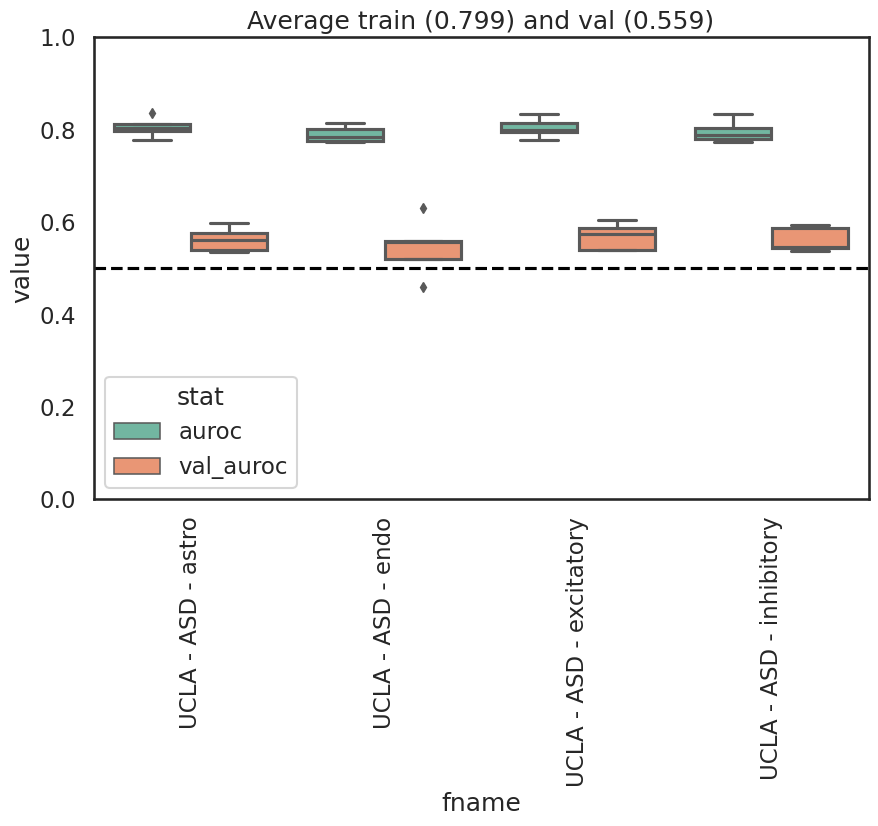

In [ ]:
# Params
stat = 'auroc'
group = 'ASD' if len(stats['fname'].iloc[0].split(' - ')) == 3 else None  # None if no filtering needed

# Format stats
df = stats.copy()
# Check if test was used
use_test = 'test_loss' in df.columns
# Filter to desired groups
if group is not None: df = df.loc[df['fname'].map(lambda s: s.split(' - ')[1] == group)]

# Filter by epoch (experimental, very important)
# NOTE: Only evaluates models which hadn't converged by epoch 20
# TODO: Try early stopping based on training acc
# min_convergence_epoch = 20
# df = df.loc[df['epochs'] >= max_lapses + min_convergence_epoch]

# Filter to desired statistics
val_stat = f'val_{stat}'
test_stat = f'test_{stat}'
eval_stat = test_stat if use_test else val_stat
cols = ['fname', stat, val_stat] + ([test_stat] if use_test else [])
df = df[cols]
# Sort by median validation stat
df = df.set_index('fname').loc[ df[['fname', eval_stat]].groupby('fname').median().sort_values(eval_stat).iloc[::-1].index.to_numpy() ].reset_index()
# Format
df = df.melt(id_vars=[cols[0]], var_name='stat')
# Overwrite
# df = df_overwrite
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.boxplot(data=df, x=cols[0], y='value', hue='stat', ax=ax)
plt.axhline(y=.5, color='black', ls='--')
plt.ylim(0, 1)
plt.xticks(rotation=90)
# Annotate
au_stat = df.loc[df['stat']==stat, 'value'].to_numpy().mean()
au_val_stat = df.loc[df['stat']==val_stat, 'value'].to_numpy().mean()
if use_test: au_test_stat = df.loc[df['stat']==test_stat, 'value'].to_numpy().mean()
if use_test:
    plt.title(f'Average train ({au_stat:.3f}), val ({au_val_stat:.3f}), and test ({au_test_stat:.3f})')
else:
    plt.title(f'Average train ({au_stat:.3f}) and val ({au_val_stat:.3f})')
fig.savefig(f'../plots/gcn_performance_{group if group is not None else "group"}_{stat}.pdf', transparent=True, bbox_inches='tight')

In [ ]:
df.loc[df['stat'] == eval_stat, ['fname', 'value']].groupby('fname').count().rename(columns={'value': 'eval_count'})

,eval_count
fname,
UCLA - ASD - astro,5
UCLA - ASD - endo,5
UCLA - ASD - excitatory,5
UCLA - ASD - inhibitory,5
UCLA - ASD - micro,5
UCLA - ASD - oligo,5
UCLA - ASD - opc,5
UCLA - ASD - vlmc,5


### Module Analysis

/home/thema/miniconda3/envs/GNN/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


ValueError: The number of observations cannot be determined on an empty distance matrix.

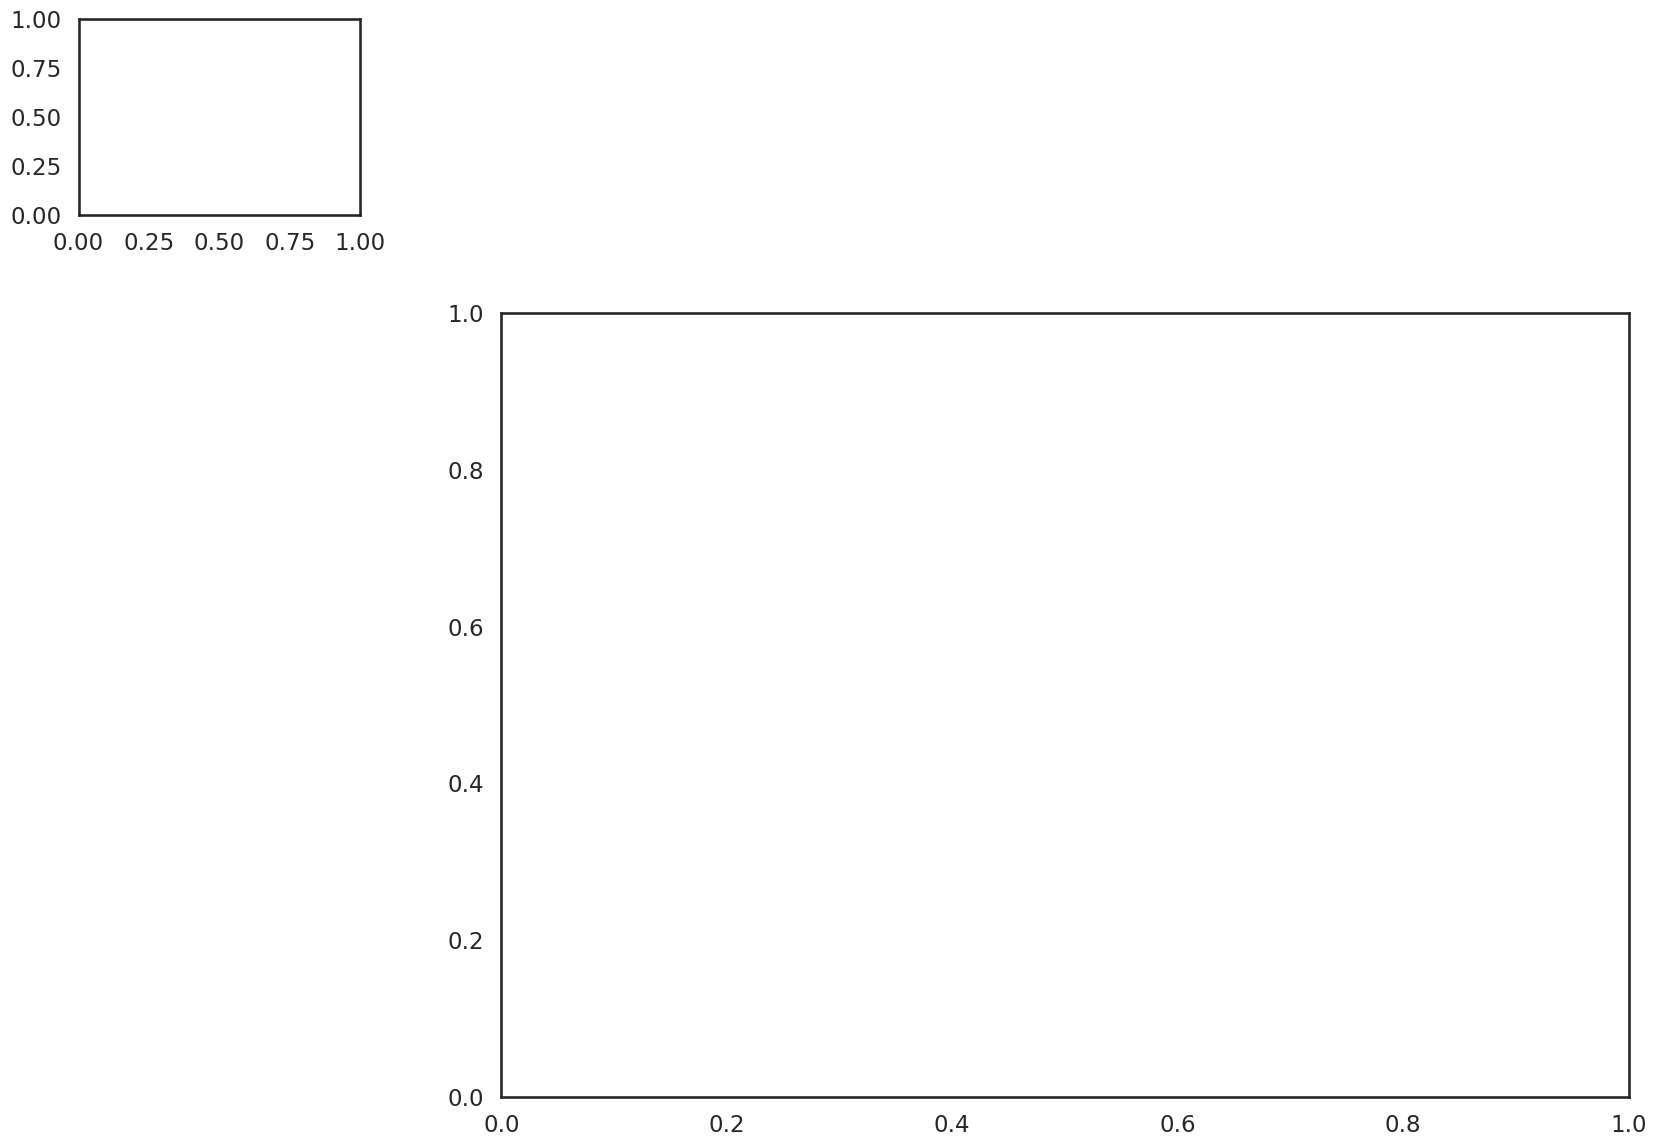

In [ ]:
# Params
target_contrast = 'c02x'
percentile_filter = 90

# Read files
df = pd.DataFrame(columns=['cell_type', 'regulon', 'score'])
for fname in fnames:
    # Get meta
    contrast = get_contrast(fname)
    group = get_group(fname)
    cell_type = get_cell_type(fname)

    # Filter to contrast
    # TODO: Filter to group as well
    if group not in gene_lists: continue
    if contrast != target_contrast: continue

    # Get TF-TG linkages
    graph_list = pd.read_csv(os.path.join(dir, fname), index_col=0)
    graph_list = graph_list.rename(columns={'gene': 'TG', 'CoexWeight': 'coex'})

    # Filtering
    graph_list = graph_list.loc[graph_list['coex'] >= np.percentile(graph_list['coex'], percentile_filter)]

    # Open results
    # TODO: Choose a fold more wisely
    scores = pd.read_csv(f'../results/{contrast}_{group}_{cell_type}_0_prioritized_genes.csv').set_index('gene')[['score']]

    # Record
    df_ct = graph_list.set_index('TF').join(scores).reset_index()[['TF', 'score']].groupby('TF').sum().reset_index().rename(columns={'TF': 'regulon'})
    df_ct['cell_type'] = cell_type
    df = pd.concat((df, df_ct))

# Format
df = df.rename(columns={'cell_type': 'Cell Type', 'regulon': 'TF (+)'}).pivot(index='Cell Type', columns='TF (+)')
df.columns = df.columns.droplevel()

# Get first appearing cell type and sort (for heatmap)
# first_ct = df.apply(lambda r: (np.arange(len(r)) * ~r.isna())[~r.isna()].min())
# first_ct = first_ct.sort_values().index.to_numpy()
# df = df[first_ct]

fig = sns.clustermap(df.fillna(0), mask=df.isna(), cmap=sns.color_palette('light:crimson', as_cmap=True), cbar_kws={'label': 'Module Score'}, figsize=(20, 14))
fig.savefig(f'../plots/module_analysis_{target_contrast}.pdf', transparent=True, bbox_inches='tight')
